# Libraries

In [1]:
import pandas as pd
import tensorflow 
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy
import re
import sklearn
from sklearn.model_selection import train_test_split
import tqdm
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from gensim.models import Word2Vec
from tensorflow.keras import Sequential
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.pipeline import make_pipeline
from tensorflow.keras import datasets,models,layers
from tensorflow.keras.layers import Conv1D, Concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D, Dense, Embedding, Input,BatchNormalization
from tensorflow.keras.models import Model

2024-05-16 15:55:44.921305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 15:55:44.921393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 15:55:45.052554: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load data

In [2]:
data = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding = 'latin',header=None)

In [3]:
data = data[[5, 0]]
data.columns=['tweet', 'sentiment']

In [4]:
data['sentiment'] = data['sentiment'].replace(4,1)

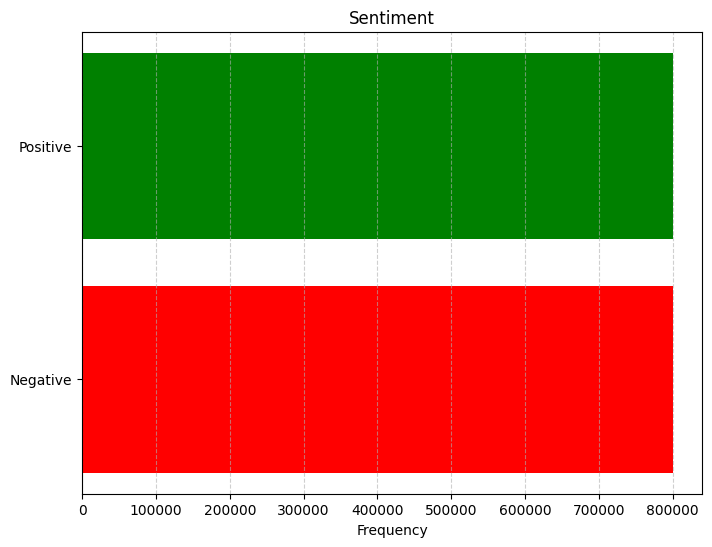

In [5]:
plt.rcParams['font.family'] = 'DejaVu Sans'
sentiment_counts = data['sentiment'].value_counts()
sentiment_labels = {'Negative': 0, 'Positive': 1}
plt.figure(figsize=(8, 6))
plt.barh(list(sentiment_labels.keys()), list(sentiment_counts.values), color=['red', 'green', 'blue'])
plt.xlabel("Frequency")
plt.yticks(list(sentiment_labels.values()), list(sentiment_labels.keys()))
plt.title("Sentiment")
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

# Preprocessing

In [6]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    # Removing URLS
    text = re.sub(r"https?://\S+|www\.\S+"," ",text)
    
    # Removing html tags
    text = re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});"," ",text)
    
    # Removing the Punctuation
    text = re.sub(r"[^\w\s]", " ", text)
        
    # Removing words that have numbers 
    text = re.sub(r"\w*\d\w*", " ", text)
        
    # Removing Digits 
    text = re.sub(r"[0-9]+", " ", text)
        
    # Cleaning white spaces
    text = re.sub(r"\s+", " ", text).strip()
        
    text = text.lower()
    # Check stop words
    tokens = []
    for token in text.split():
        if token not in stop_words and len(token) > 3:
            tokens.append(token)
    return " ".join(tokens)

In [7]:
data.loc[:, 'tweet'] = data['tweet'].apply(preprocess)

# Split Data

In [8]:
X = data['tweet']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

print("Train Data size:", len(X_train), len(y_train))
print("Test Data size", len(X_test), len(y_test))

Train Data size: 1280000 1280000
Test Data size 320000 320000


In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of integers
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [10]:
max_length = max([len(seq) for seq in X_train])
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)
print(f"After padding: {X_train.shape}")
print(f"After padding:{X_test.shape}")

After padding: (1280000, 27)
After padding:(320000, 27)


In [11]:
batch_size=512
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 100

In [12]:
CNN=models.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    layers.Dropout(0.5),
    
    layers.Conv1D(filters=256, kernel_size=3, activation='relu'), 
    layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
    layers.GlobalMaxPooling1D(),
    
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dropout(0.5),
    
    layers.Dense(1, activation='sigmoid')
])

CNN.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
history=CNN.fit(X_train, y_train, epochs=20,batch_size=batch_size)

Epoch 1/20
  13/2500 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.5003 - loss: 0.6940

I0000 00:00:1715875117.074073     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.7234 - loss: 0.5329
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.8116 - loss: 0.4181
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.8477 - loss: 0.3436
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.8647 - loss: 0.3033
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.8740 - loss: 0.2825
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.8816 - loss: 0.2664
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.8871 - loss: 0.2538
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.8927 - loss: 0.2421
Epoch 9/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.8964 - loss: 0.2337
Epoch 10/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.8997 - loss: 0.2262
Epoch 11/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.9034 - loss: 0.2185
Epoch 12/20
2500/25

In [14]:
CNN.evaluate(X_test, y_test)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.7359 - loss: 1.2702


[1.2717556953430176, 0.7359281182289124]

In [15]:
CNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (512, 27, 100)         │    45,102,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (512, 27, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (512, 25, 256)         │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (512, 23, 256)         │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (512, 256)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (512, 256)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (512, 128)             │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (512, 128)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (512, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,228,937 (519.67 MB)

 Trainable params: 45,409,645 (173.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 90,819,292 (346.45 MB)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


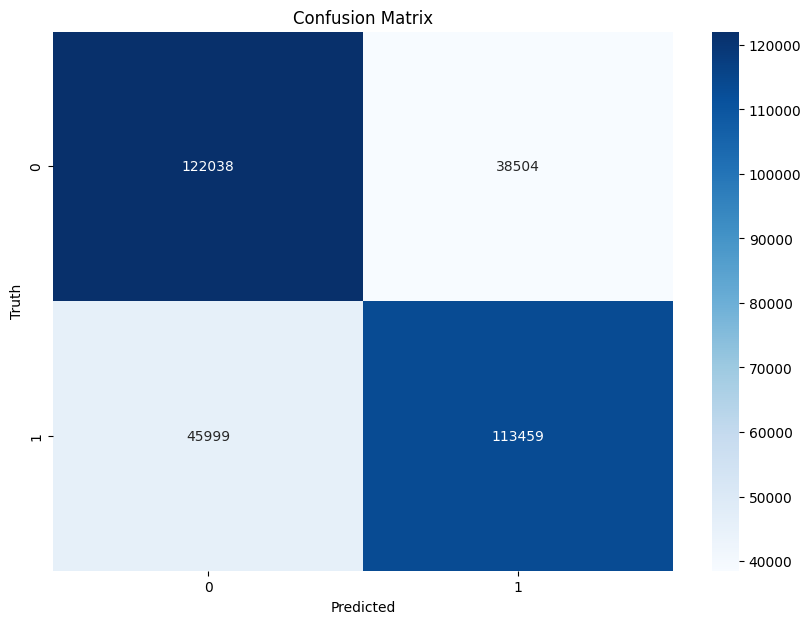

In [16]:

import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
y_pred = CNN.predict(X_test)
y_pred_rounded = np.round(y_pred)
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_rounded)
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [17]:

from sklearn.metrics import classification_report


# Print classification report
print(classification_report(y_test, y_pred_rounded, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.73      0.76      0.74    160542
    Positive       0.75      0.71      0.73    159458

    accuracy                           0.74    320000
   macro avg       0.74      0.74      0.74    320000
weighted avg       0.74      0.74      0.74    320000



# VGG-16 architecture

In [18]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Model

# Define the model
embedding_layer = Embedding(vocab_size, 100, input_length=max_length, trainable=False)
sequence_input = Input(shape=(max_length,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

x = Conv1D(64, 3, activation='relu', padding='same')(embedding_sequences)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
x= MaxPooling1D(pool_size=3, strides=1, padding='same')(x)

x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)

x = Conv1D(256, 3, activation='relu', padding='same')(x)
x = Conv1D(256, 3, activation='relu', padding='same')(x)
x = Conv1D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)

x = Conv1D(512, 3, activation='relu', padding='same')(x)
x = Conv1D(512, 3, activation='relu', padding='same')(x)
x = Conv1D(512, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)

x = Conv1D(512, 3, activation='relu', padding='same')(x)
x = Conv1D(512, 3, activation='relu', padding='same')(x)
x = Conv1D(512, 3, activation='relu', padding='same')(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(1, activation='sigmoid')(x)

model_vgg16 = Model(sequence_input, outputs)

# Compile the model
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
history = model_vgg16.fit(X_train, y_train, batch_size=64, epochs=5)

Epoch 1/5
   13/20000 ━━━━━━━━━━━━━━━━━━━━ 5:07 15ms/step - accuracy: 0.4681 - loss: 0.6937

W0000 00:00:1715875811.215578     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 321s 16ms/step - accuracy: 0.5006 - loss: 0.6932
Epoch 2/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 309s 15ms/step - accuracy: 0.5011 - loss: 0.6932
Epoch 3/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 318s 15ms/step - accuracy: 0.5010 - loss: 0.6932
Epoch 4/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 306s 15ms/step - accuracy: 0.5010 - loss: 0.6932
Epoch 5/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 306s 15ms/step - accuracy: 0.5001 - loss: 0.6932


In [20]:
loss, accuracy = model_vgg16.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.4975 - loss: 0.6932
Test Loss: 0.6931653022766113
Test Accuracy: 0.4983062446117401


In [21]:
model_vgg16.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 27, 100)        │    45,102,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 27, 64)         │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 27, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 27, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 27, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 27, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 27, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 27, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 27, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 27, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 27, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 27, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 27, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 27, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 27, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 27, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,906,417 (312.45 MB)

 Trainable params: 12,267,905 (46.80 MB)

 Non-trainable params: 45,102,700 (172.05 MB)

 Optimizer params: 24,535,812 (93.60 MB)

# Inception Architecture

In [22]:
# Define the model
sequence_input = Input(shape=(max_length,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

l1 = Conv1D(64, 1, activation='relu', padding='same')(embedding_sequences)
l2 = Conv1D(64, 3, activation='relu', padding='same')(embedding_sequences)
l3 = Conv1D(64, 5, activation='relu', padding='same')(embedding_sequences)
l4 = Conv1D(64, 7, activation='relu', padding='same')(embedding_sequences)
l5 = Conv1D(64, 9, activation='relu', padding='same')(embedding_sequences)
l6 = MaxPooling1D(pool_size=3, strides=1, padding='same')(embedding_sequences)
l6 = Conv1D(64, 1, activation='relu', padding='same')(l6)

l = Concatenate(axis=-1)([l1, l2, l3, l4, l5, l6])
l = Flatten()(l)
l = Dense(512, activation='relu')(l)
l = Dense(512, activation='relu')(l)

outputs = Dense(1, activation='sigmoid')(l)

model_inception = Model(sequence_input, outputs)

# Compile the model
model_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [23]:
history = model_inception.fit(X_train, y_train, batch_size=64, epochs=5)

Epoch 1/5
   35/20000 ━━━━━━━━━━━━━━━━━━━━ 1:30 5ms/step - accuracy: 0.4971 - loss: 0.7182

W0000 00:00:1715877403.876977     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 93s 4ms/step - accuracy: 0.6956 - loss: 0.5652
Epoch 2/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 89s 4ms/step - accuracy: 0.7461 - loss: 0.5072
Epoch 3/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 89s 4ms/step - accuracy: 0.7625 - loss: 0.4840
Epoch 4/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 91s 5ms/step - accuracy: 0.7799 - loss: 0.4569
Epoch 5/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 92s 5ms/step - accuracy: 0.7985 - loss: 0.4263


In [24]:
loss, accuracy = model_inception.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.7380 - loss: 0.5412
Test Loss: 0.5416120290756226
Test Accuracy: 0.7376031279563904


In [25]:
model_inception.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 27)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 27, 100)   │ 45,102,700 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 27, 100)   │          0 │ embedding_1[1][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 27, 64)    │      6,464 │ embedding_1[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 27, 64)    │     19,264 │ embedding_1[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 27, 64)    │     32,064 │ embedding_1[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 27, 64)    │     44,864 │ embedding_1[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 27, 64)    │     57,664 │ embedding_1[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 27, 64)    │      6,464 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 27, 384)   │          0 │ conv1d_15[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_16[0][0],  │
│                     │                   │            │ conv1d_17[0][0],  │
│                     │                   │            │ conv1d_18[0][0],  │
│                     │                   │            │ conv1d_19[0][0],  │
│                     │                   │            │ conv1d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 10368)     │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │  5,308,928 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │    262,656 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        513 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 62,319,345 (237.73 MB)

 Trainable params: 5,738,881 (21.89 MB)

 Non-trainable params: 45,102,700 (172.05 MB)

 Optimizer params: 11,477,764 (43.78 MB)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


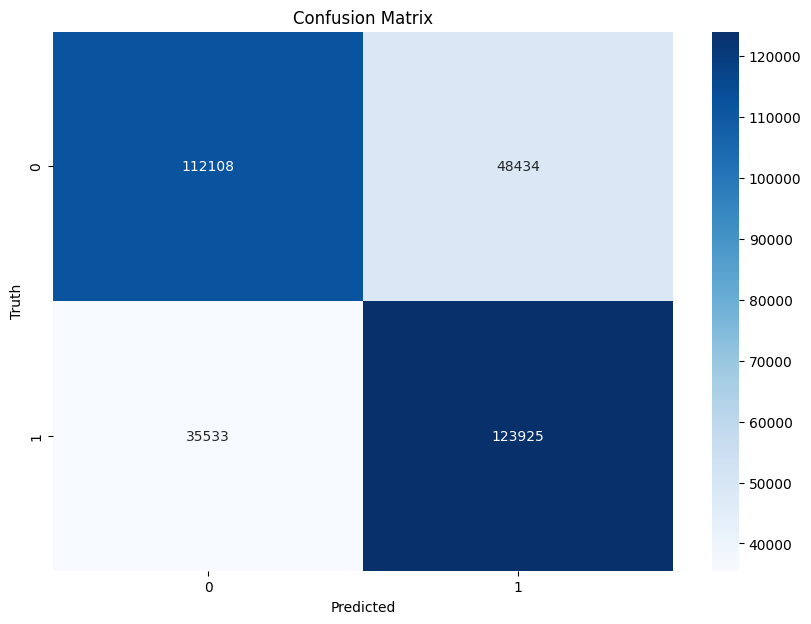

In [26]:
y_pred = model_inception.predict(X_test)
y_pred_rounded = np.round(y_pred)
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_rounded)
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [27]:

from sklearn.metrics import classification_report


# Print classification report
print(classification_report(y_test, y_pred_rounded, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.76      0.70      0.73    160542
    Positive       0.72      0.78      0.75    159458

    accuracy                           0.74    320000
   macro avg       0.74      0.74      0.74    320000
weighted avg       0.74      0.74      0.74    320000



In [31]:
def predict_sentiments(model, tokenizer, data, num_samples=10):
    results = []
    for _ in range(num_samples):
        index = np.random.randint(0, len(data))
        tweet = data.iloc[index]['tweet']
        y_true = data.iloc[index]['sentiment']
        cleaned_tweet = preprocess(tweet)
        sequence = tokenizer.texts_to_sequences([cleaned_tweet])
        padded_sequence = pad_sequences(sequence, maxlen=max_length)
        prediction = model.predict(padded_sequence)[0][0]
        sentiment = "Positive" if prediction >= 0.5 else "Negative"
        results.append((tweet, sentiment, y_true))

    return results

results = predict_sentiments(CNN, tokenizer, data, num_samples=10)
for i, (tweet, sentiment, y_true) in enumerate(results, 1):
    print(f"Sample {i}:")
    print("Tweet:", tweet)
    print("Predicted Sentiment:", sentiment)
    print("True Sentiment:", "Positive" if y_true == 1 else "Negative")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 1:
Tweet: left starbucks liya brandon
Predicted Sentiment: Positive
True Sentiment: Positive

Sample 2:
Tweet: miss nice weather already
Predicted Sentiment: Negative
True Sentiment: Negative

Sample 3:
Tweet: rosaliehalegirl sweet gotta though talk soon
Predicted Sentiment: Positive
True Sentiment: Positive

Sample 4:
Tweet: first weekend without
Predicted Sentiment: Negative
True Sentiment: Negative

Sample 5:
Tweet: eating nandos chips train peri peri
Predicted Sentiment: Positive
True Sentiment: Positive

Sample 6:
Tweet: chris_gorham love show watch watch harper island
Predicted Sentiment: Positive
T